In [43]:
import sys,os
import time
import collections
sys.path.append(os.path.abspath("../../"))
sys.path.append(os.path.abspath('../../modules/'))
from modules.settings import global_mmf_settings as gset
from modules import cnc_mmf_bias_study
from modules.masking import gen_masks as gm

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def colorbar(mappable):
	ax = mappable.axes
	fig = ax.figure
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.05)
	return fig.colorbar(mappable, cax=cax)
        
figpath="./results/mmf_results_170221/"

ensure_dir(figpath)
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colorbar', 'char']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
dataset="planck_psm_sim"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=False
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

outpath=figpath + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath=figpath + "/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

emask=gm.return_edge_apodized_mask(edge_width=30,fwhm=30)

In [3]:
cmbs=cnc_mmf_bias_study.mmf_anasim()

In [7]:
cmbs.simulate_mf_cluster(5,0.1,sampling=10)

In [17]:
lbls=["AK","LK","SK","NK"]

start=time.time()

cl_char_nvk=collections.OrderedDict()
cl_char_nvk["snr"]=np.zeros((len(cmbs.yc_inp),len(lbls),cmbs.nrlz)) 
cl_char_nvk["yc"]=np.zeros((len(cmbs.yc_inp),len(lbls),cmbs.nrlz)) 
cl_char_nvk["thetac"]=np.zeros((len(cmbs.yc_inp),len(lbls),cmbs.nrlz))

for iy, yc in enumerate(cmbs.yc_inp):
    print iy
    for n in range(cmbs.nrlz):
        data=cmbs.ymap[iy,] + cmbs.noise[n,]
        soln=cmbs.analyse(data,thetac=cmbs.theta500)
        cl_char_nvk["yc"][iy,:,n]=[soln["AK"][0],soln["SK"][0],soln["LK"][0],soln["NK"][0]]
        cl_char_nvk["snr"][iy,:,n]=[soln["AK"][1],soln["SK"][1],soln["LK"][1],soln["NK"][1]]
        cl_char_nvk["thetac"][iy,:,n]=[soln["AK"][2],soln["SK"][2],soln["LK"][2],soln["NK"][2]]
print time.time()-start

0
1
2
3
4
5
6
7
8
9
1758.44905186


In [22]:
char_stat=collections.OrderedDict()
char_stat["snr"]=np.zeros((len(cmbs.yc_inp),len(lbls),2))
char_stat["yc"]=np.zeros((len(cmbs.yc_inp),len(lbls),2))
char_stat["thetac"]=np.zeros((len(cmbs.yc_inp),len(lbls),2))

for iy,yc in enumerate(cmbs.yc_inp):
    for i in range(len(lbls)):
        for k in cl_char_nvk.keys():
            char_stat[k][iy,i,0]=np.mean(cl_char_nvk[k][iy,i,:])
            char_stat[k][iy,i,1]=np.std(cl_char_nvk[k][iy,i,:])

In [26]:
lbls=["AK","SK","LK","NK"]

<IPython.core.display.Javascript object>


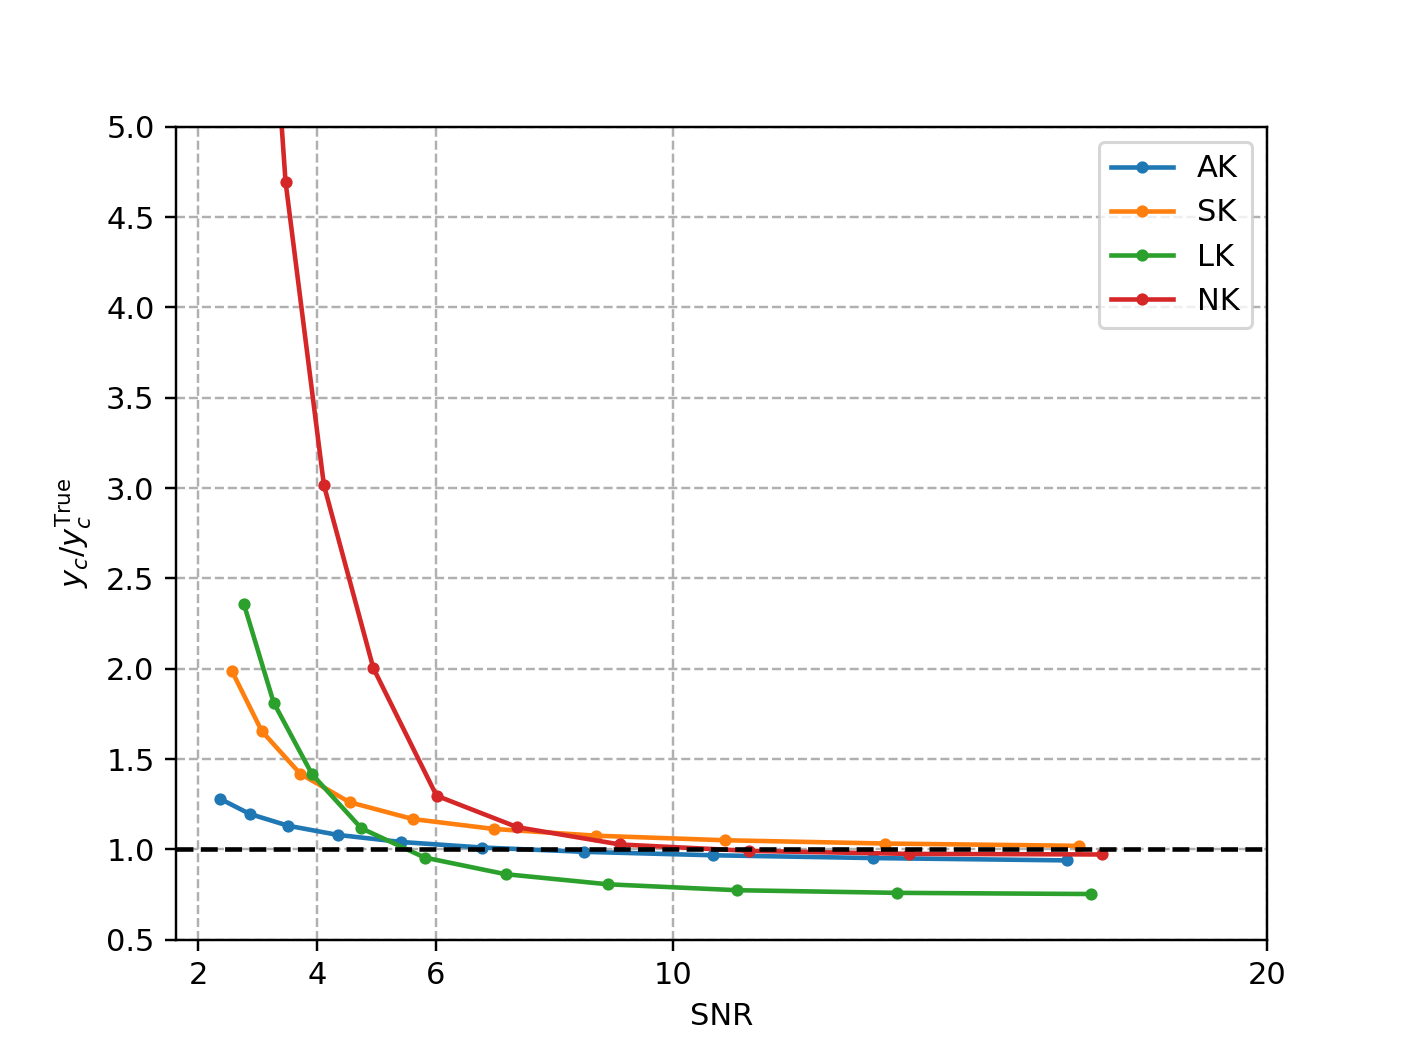

<IPython.core.display.Javascript object>


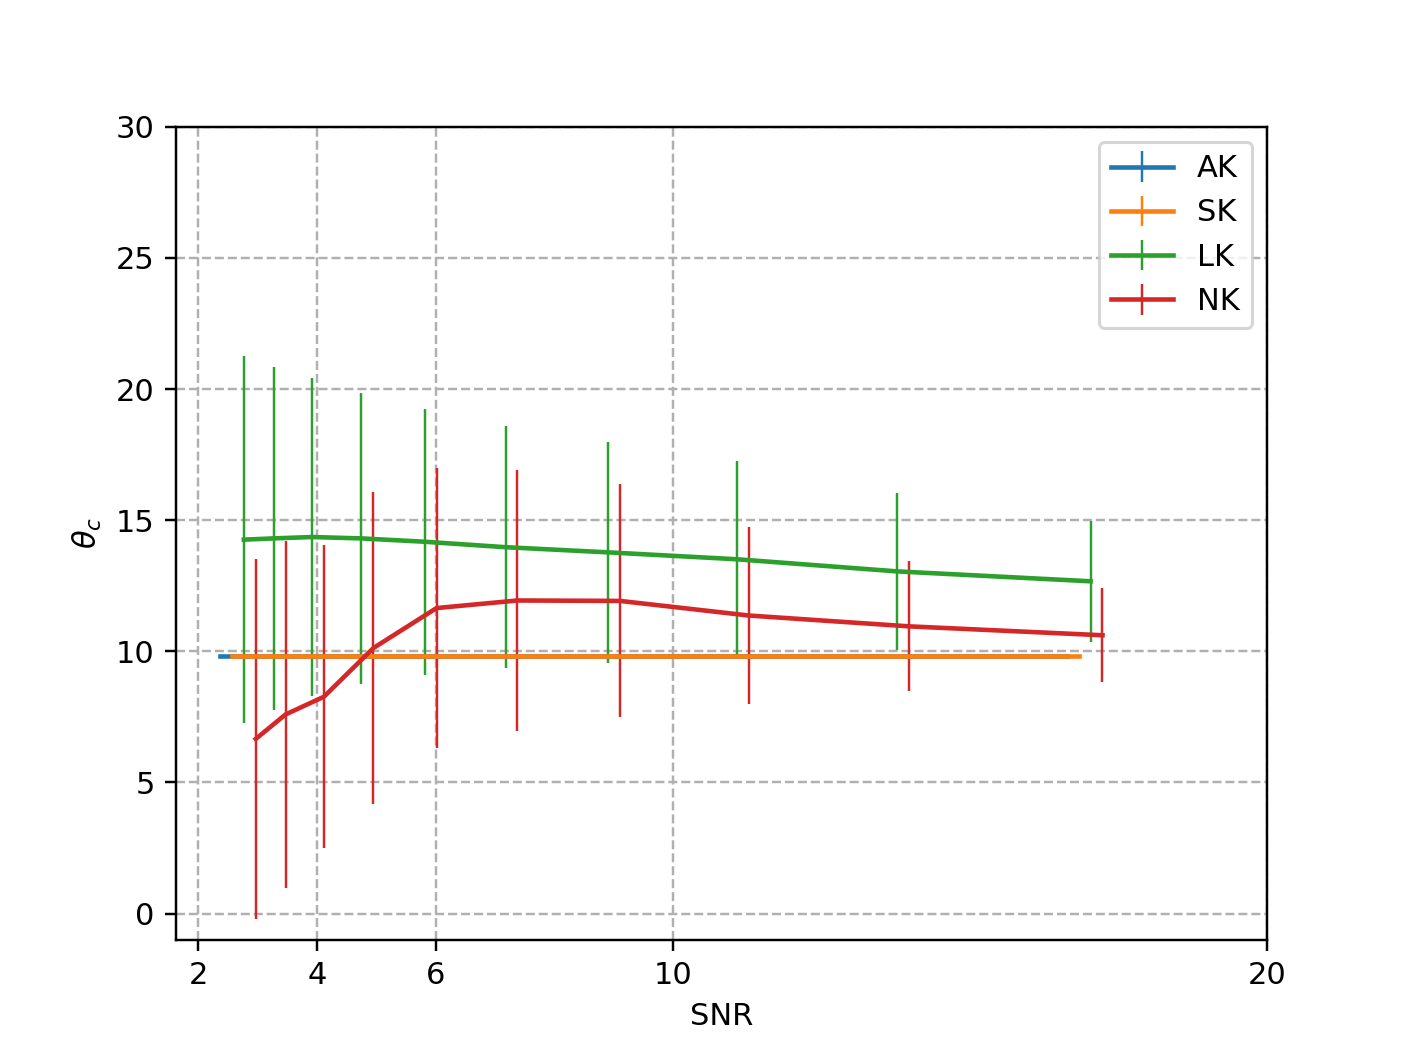

<IPython.core.display.Javascript object>


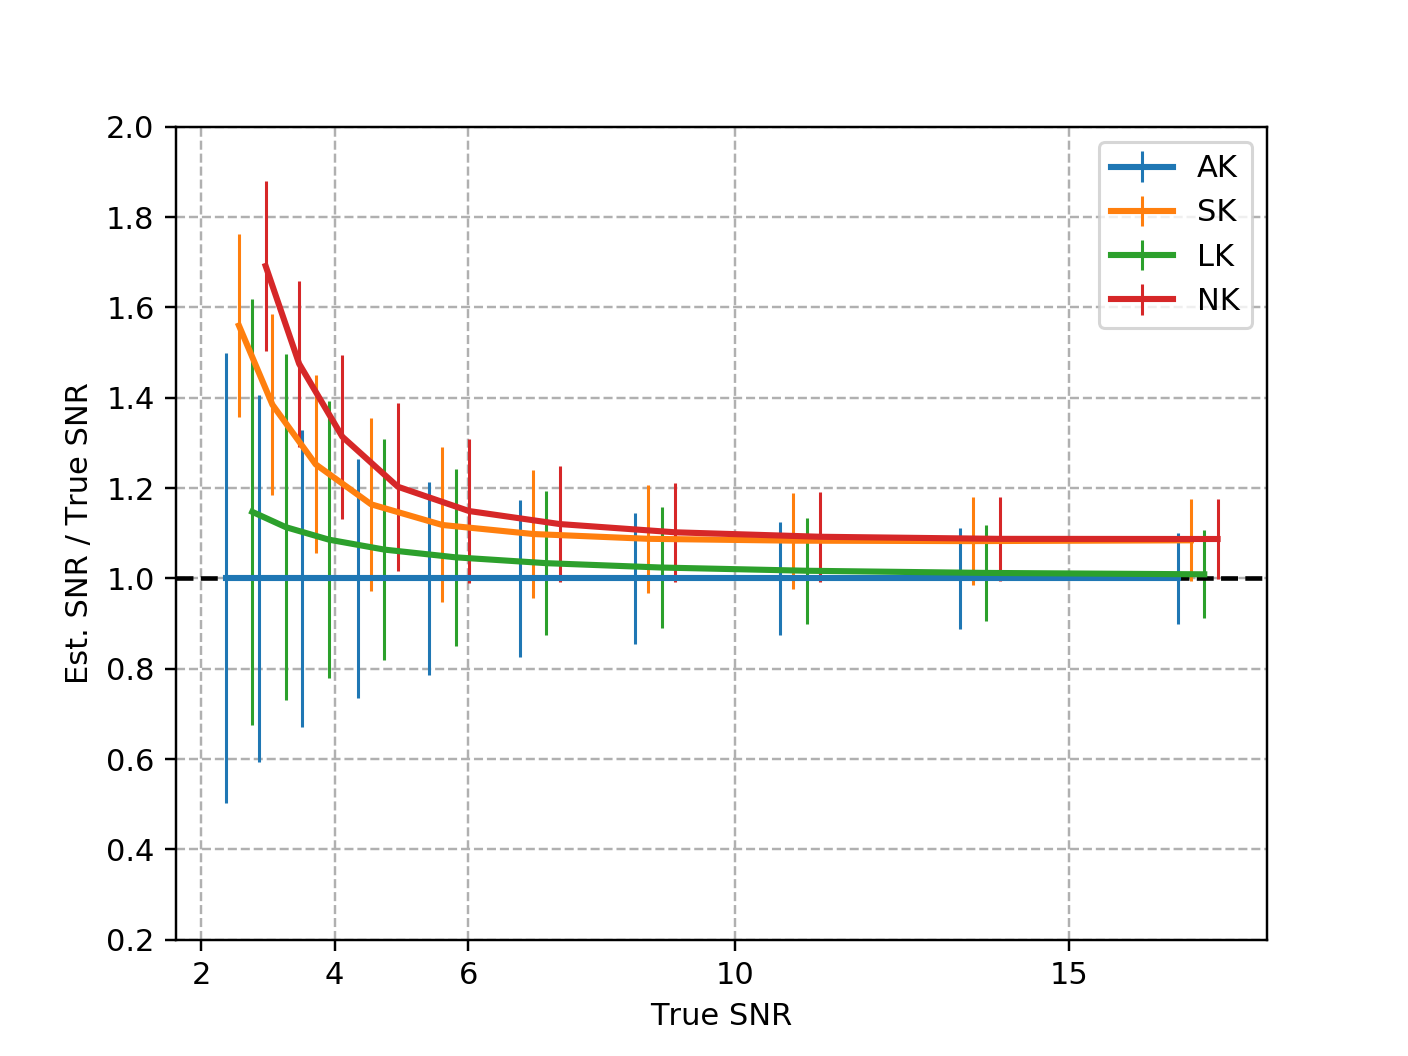

In [30]:
char="yc"
figure()
for i, lbl in enumerate(lbls):
    plot(char_stat["snr"][:,0,0]+i*0.2,char_stat[char][:,i,0]/cmbs.yc_inp,".-",label=lbl)
legend(loc=0,fontsize=10)
axhline(1,linestyle="dashed",c="k")

xticks([2,4,6,10,20],[2,4,6,10,20])
# yticks([2,4,6,8],[2,4,6,8])
ylim(0.5,5)
# loglog()
xlabel("SNR",fontsize=10)
ylabel(r"$y_c/y_c^{\rm True}$",fontsize=10)
grid(which="both",linestyle="dashed")
figname=figpath + "yc_revovery.pdf"
savefig(figname,bbox_inches="tight")


char="thetac"
figure()
for i, lbl in enumerate(lbls):
    errorbar(char_stat["snr"][:,0,0]+i*0.2,char_stat[char][:,i,0],yerr=char_stat[char][:,i,1],label=lbl,elinewidth=0.8)
# axhline(1,linestyle="dashed",c="k")
legend(loc=0,fontsize=10)
# loglog()
xticks([2,4,6,10,20],[2,4,6,10,20])
ylim(-1,30)
xlabel("SNR",fontsize=10)
ylabel(r"$\theta_c$",fontsize=10)
grid(which="both",linestyle="dashed")
figname=figpath + "size_revovery.pdf"
savefig(figname,bbox_inches="tight")

char="snr"
figure()
for i, lbl in enumerate(lbls):
    errorbar(char_stat["snr"][:,0,0]+i*0.2,char_stat[char][:,i,0]/char_stat[char][:,0,0],yerr=char_stat["snr"][:,i,1]/char_stat[char][:,0,0],lw=2,label=lbl,elinewidth=1)
legend()
legend(loc=0,fontsize=10)
axhline(1,c="k",linestyle="dashed")
# loglog()
xticks([2,4,6,10,15],[2,4,6,10,15])
ylim(0.2,2)
xlabel("True SNR",fontsize=10)
ylabel("Est. SNR / True SNR",fontsize=10)
grid(which="both",linestyle="dashed")
figname=figpath + "snr_revovery.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


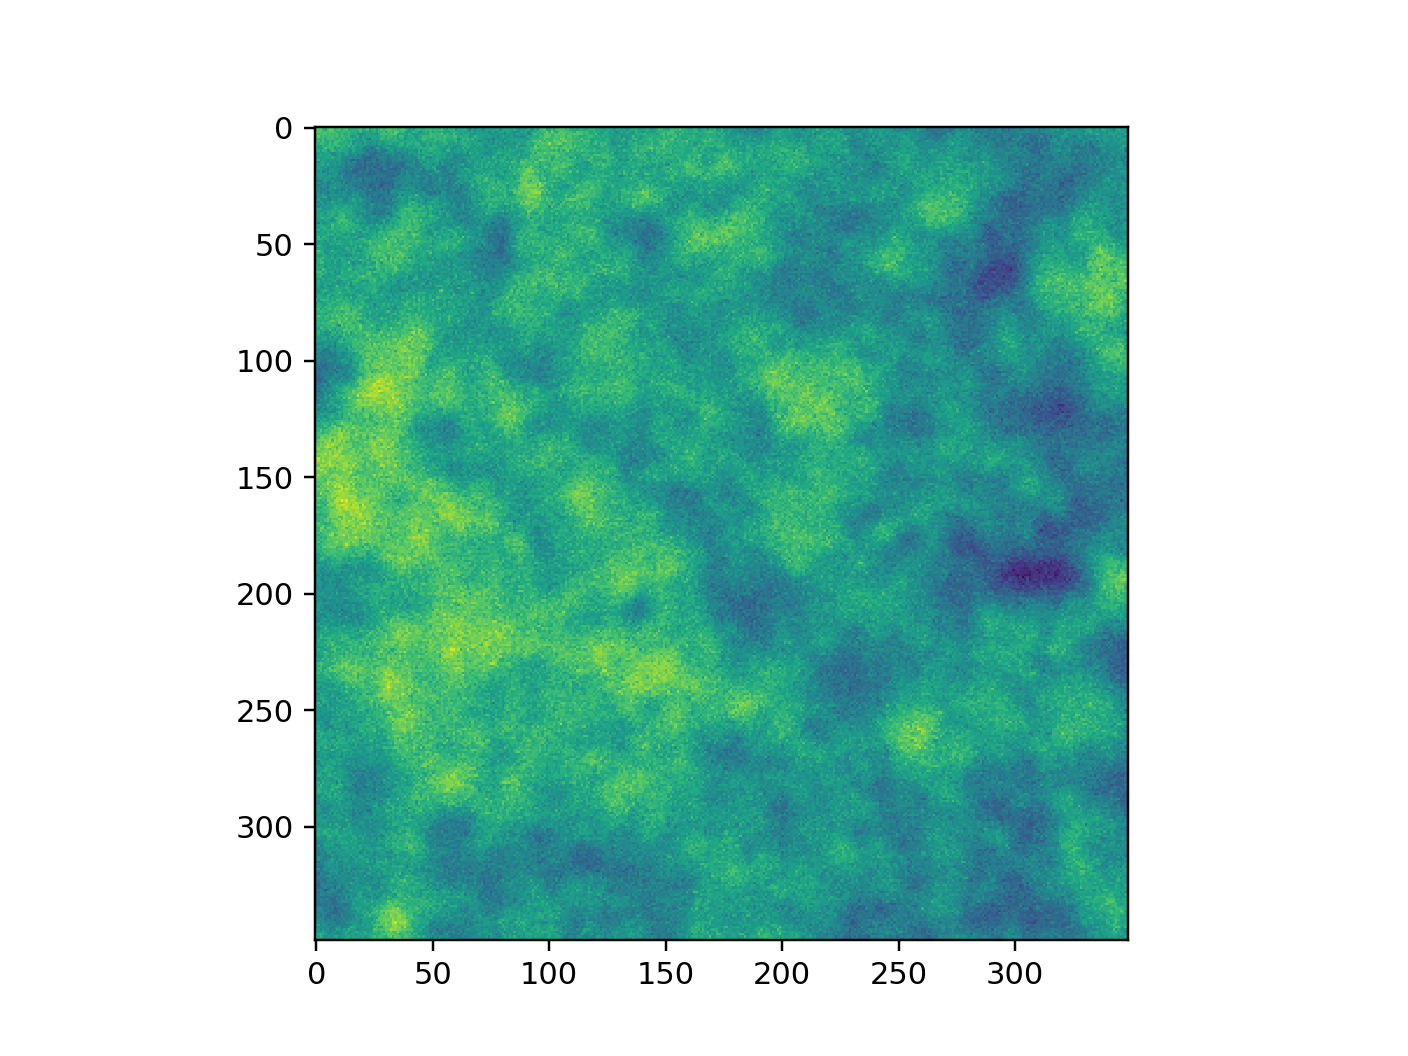

In [31]:
figure()
imshow(cmbs.noise[0,0],origin="lower")

<IPython.core.display.Javascript object>


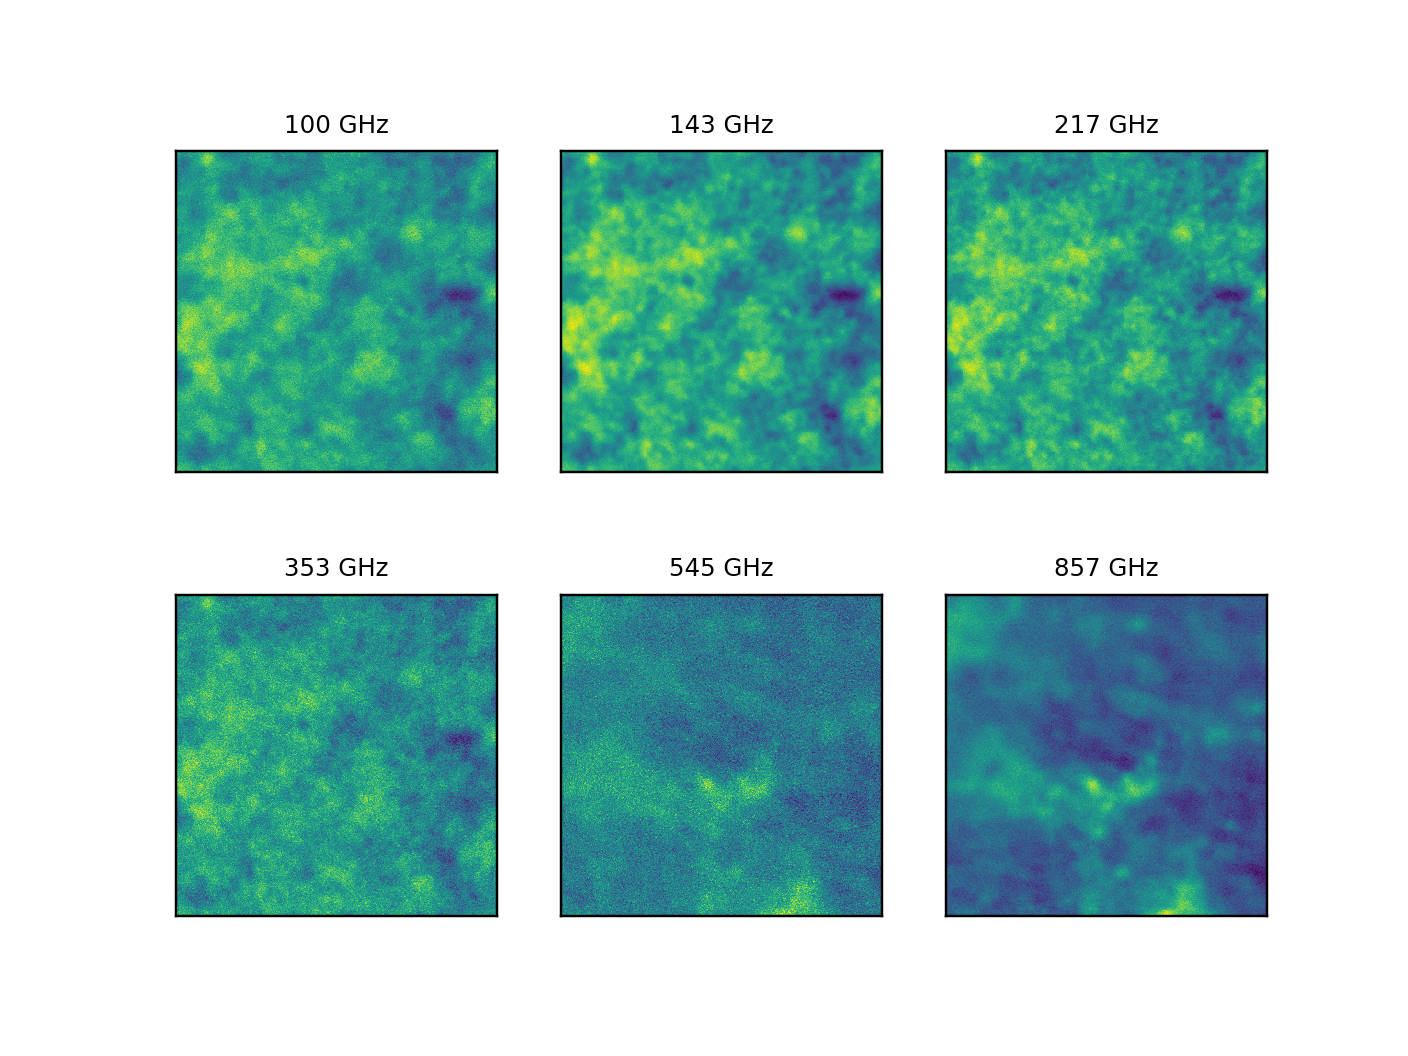

In [52]:
data=cmbs.noise[0,]
fig, ax = plt.subplots(ncols=3,nrows=2)
img1=ax[0,0].imshow(data[0,]*1e6,origin="lower") #; colorbar(img1)
ax[0,0].set_title("100 GHz",fontsize=8) ; ax[0,0].axes.get_xaxis().set_visible(False) ; ax[0,0].axes.get_yaxis().set_visible(False)
img2=ax[0,1].imshow(data[1,]*1e6,origin="lower") #; colorbar(img2)
ax[0,1].set_title("143 GHz",fontsize=8) ; ax[0,1].axes.get_xaxis().set_visible(False) ; ax[0,1].axes.get_yaxis().set_visible(False)
img2=ax[0,2].imshow(data[2,]*1e6,origin="lower") #; colorbar(img2)
ax[0,2].set_title("217 GHz",fontsize=8) ; ax[0,2].axes.get_xaxis().set_visible(False) ; ax[0,2].axes.get_yaxis().set_visible(False)

img1=ax[1,0].imshow(data[3,]*1e6,origin="lower") #; colorbar(img1)
ax[1,0].set_title("353 GHz",fontsize=8) ; ax[1,0].axes.get_xaxis().set_visible(False) ; ax[1,0].axes.get_yaxis().set_visible(False)
img2=ax[1,1].imshow(data[4,]*1e6,origin="lower") #; colorbar(img2)
ax[1,1].set_title("545 GHz",fontsize=8) ; ax[1,1].axes.get_xaxis().set_visible(False) ; ax[1,1].axes.get_yaxis().set_visible(False)
img2=ax[1,2].imshow(data[5,]*1e6,origin="lower") #; colorbar(img2)
ax[1,2].set_title("857 GHz",fontsize=8) ; ax[1,2].axes.get_xaxis().set_visible(False) ; ax[1,2].axes.get_yaxis().set_visible(False)

figname=figpath + "noise_rlz_0.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


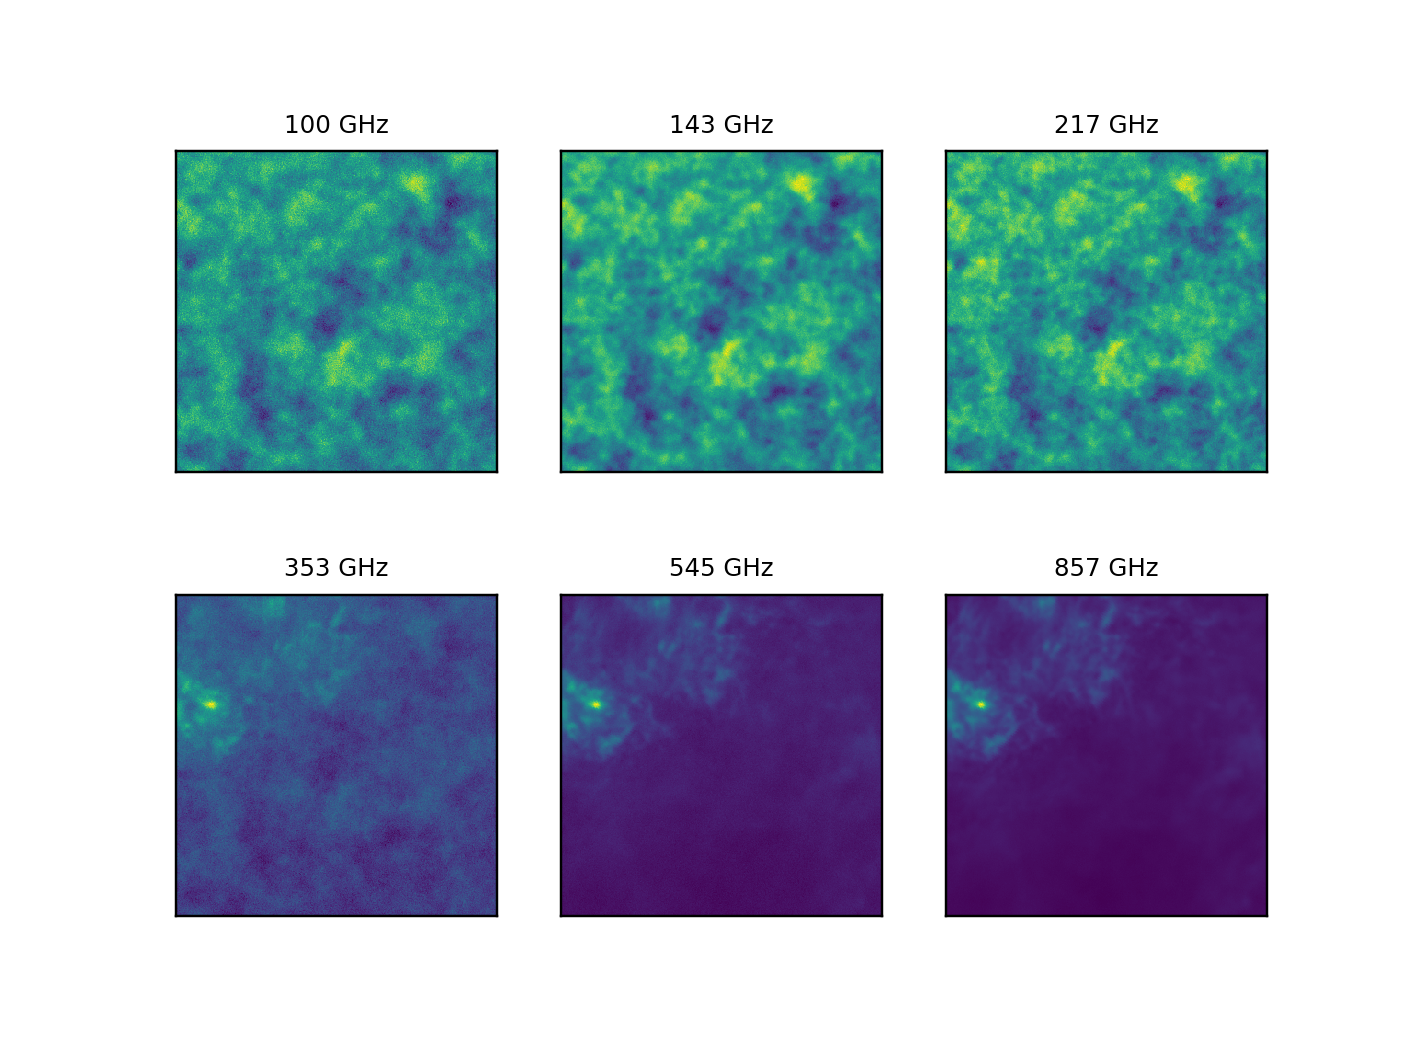

In [53]:
data=cmbs.noise[1,]
fig, ax = plt.subplots(ncols=3,nrows=2)
img1=ax[0,0].imshow(data[0,]*1e6,origin="lower") #; colorbar(img1)
ax[0,0].set_title("100 GHz",fontsize=8) ; ax[0,0].axes.get_xaxis().set_visible(False) ; ax[0,0].axes.get_yaxis().set_visible(False)
img2=ax[0,1].imshow(data[1,]*1e6,origin="lower") #; colorbar(img2)
ax[0,1].set_title("143 GHz",fontsize=8) ; ax[0,1].axes.get_xaxis().set_visible(False) ; ax[0,1].axes.get_yaxis().set_visible(False)
img2=ax[0,2].imshow(data[2,]*1e6,origin="lower") #; colorbar(img2)
ax[0,2].set_title("217 GHz",fontsize=8) ; ax[0,2].axes.get_xaxis().set_visible(False) ; ax[0,2].axes.get_yaxis().set_visible(False)

img1=ax[1,0].imshow(data[3,]*1e6,origin="lower") #; colorbar(img1)
ax[1,0].set_title("353 GHz",fontsize=8) ; ax[1,0].axes.get_xaxis().set_visible(False) ; ax[1,0].axes.get_yaxis().set_visible(False)
img2=ax[1,1].imshow(data[4,]*1e6,origin="lower") #; colorbar(img2)
ax[1,1].set_title("545 GHz",fontsize=8) ; ax[1,1].axes.get_xaxis().set_visible(False) ; ax[1,1].axes.get_yaxis().set_visible(False)
img2=ax[1,2].imshow(data[5,]*1e6,origin="lower") #; colorbar(img2)
ax[1,2].set_title("857 GHz",fontsize=8) ; ax[1,2].axes.get_xaxis().set_visible(False) ; ax[1,2].axes.get_yaxis().set_visible(False)

figname=figpath + "noise_rlz_1.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


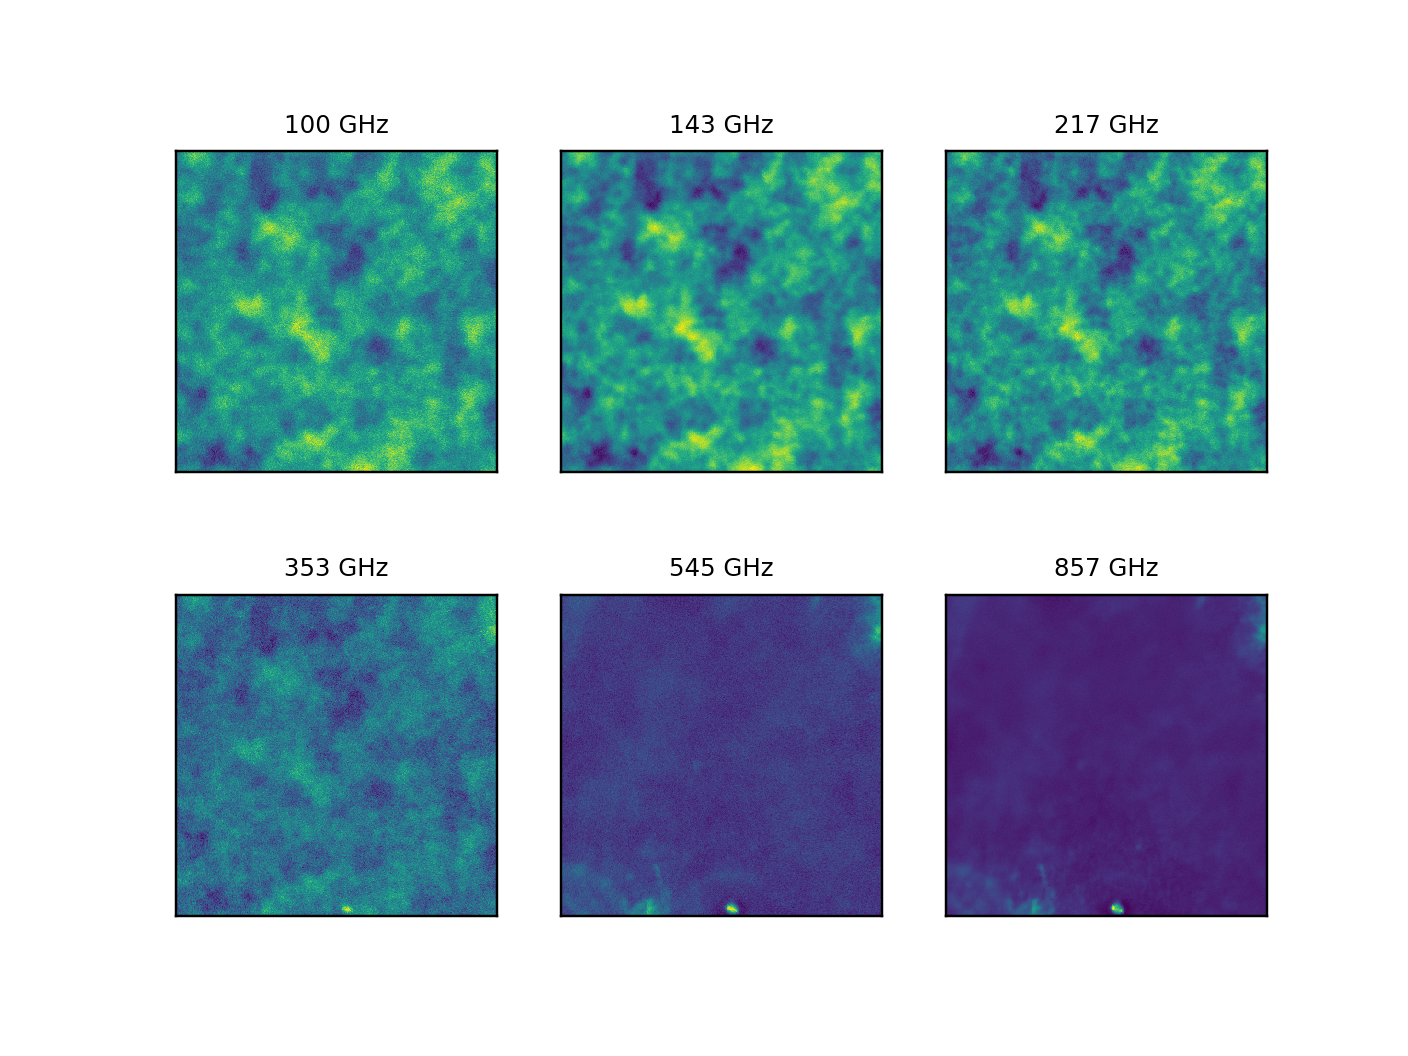

In [58]:
data=cmbs.noise[2,] + 0*cmbs.ymap[9,]
fig, ax = plt.subplots(ncols=3,nrows=2)
img1=ax[0,0].imshow(data[0,]*1e6,origin="lower") #; colorbar(img1)
ax[0,0].set_title("100 GHz",fontsize=8) ; ax[0,0].axes.get_xaxis().set_visible(False) ; ax[0,0].axes.get_yaxis().set_visible(False)
img2=ax[0,1].imshow(data[1,]*1e6,origin="lower") #; colorbar(img2)
ax[0,1].set_title("143 GHz",fontsize=8) ; ax[0,1].axes.get_xaxis().set_visible(False) ; ax[0,1].axes.get_yaxis().set_visible(False)
img2=ax[0,2].imshow(data[2,]*1e6,origin="lower") #; colorbar(img2)
ax[0,2].set_title("217 GHz",fontsize=8) ; ax[0,2].axes.get_xaxis().set_visible(False) ; ax[0,2].axes.get_yaxis().set_visible(False)

img1=ax[1,0].imshow(data[3,]*1e6,origin="lower") #; colorbar(img1)
ax[1,0].set_title("353 GHz",fontsize=8) ; ax[1,0].axes.get_xaxis().set_visible(False) ; ax[1,0].axes.get_yaxis().set_visible(False)
img2=ax[1,1].imshow(data[4,]*1e6,origin="lower") #; colorbar(img2)
ax[1,1].set_title("545 GHz",fontsize=8) ; ax[1,1].axes.get_xaxis().set_visible(False) ; ax[1,1].axes.get_yaxis().set_visible(False)
img2=ax[1,2].imshow(data[5,]*1e6,origin="lower") #; colorbar(img2)
ax[1,2].set_title("857 GHz",fontsize=8) ; ax[1,2].axes.get_xaxis().set_visible(False) ; ax[1,2].axes.get_yaxis().set_visible(False)

figname=figpath + "data_rlz_1.pdf"
savefig(figname,bbox_inches="tight")